In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
#The problem we’re going to solve today is to train a model to classify ants and bees.
#We have about 120 training images each for ants and bees.
#There are 75 validation images for each class. 
#Usually, this is a very small dataset to generalize upon, if trained from scratch.
#Since we are using transfer learning,
#we should be able to generalize reasonably well.

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #new dimensions 224x224
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [6]:
data_dir = '/home/ahisham/Documents/pytorch_endtoend/torch_CNN_training/hymenoptera_data'

In [7]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [8]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

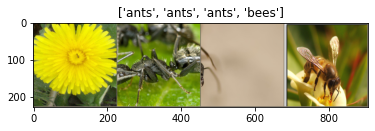

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ahisham/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5281 Acc: 0.7377
val Loss: 0.1739 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.5540 Acc: 0.7623
val Loss: 0.3133 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4829 Acc: 0.8033
val Loss: 0.3317 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.4812 Acc: 0.8115
val Loss: 0.2948 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.4355 Acc: 0.8361
val Loss: 0.5313 Acc: 0.8235

Epoch 5/24
----------
train Loss: 0.3799 Acc: 0.8443
val Loss: 0.4000 Acc: 0.8497

Epoch 6/24
----------
train Loss: 0.5088 Acc: 0.7910
val Loss: 0.2688 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3371 Acc: 0.8402
val Loss: 0.2246 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.2544 Acc: 0.8893
val Loss: 0.2046 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3729 Acc: 0.8525
val Loss: 0.2125 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3209 Acc: 0.8607
val Loss: 0.2127 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.2653 Acc: 0.9098
val Loss: 0.2064 Acc: 0.9020

Ep

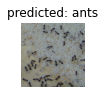

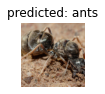

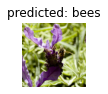

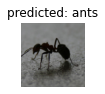

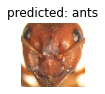

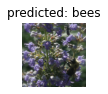

In [16]:
visualize_model(model_ft)

In [17]:
#ConvNet as fixed feature extractor
#Here,
#we need to freeze all the network except the final layer.
#We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().



In [18]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [19]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7254 Acc: 0.6557
val Loss: 0.3765 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.6924 Acc: 0.7008
val Loss: 0.3889 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.4311 Acc: 0.8074
val Loss: 0.2619 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.3900 Acc: 0.8156
val Loss: 0.2580 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.4633 Acc: 0.8033
val Loss: 0.2180 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.4774 Acc: 0.7992
val Loss: 0.3244 Acc: 0.8954

Epoch 6/24
----------
train Loss: 0.4736 Acc: 0.8074
val Loss: 0.1980 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3815 Acc: 0.8525
val Loss: 0.2036 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3376 Acc: 0.8402
val Loss: 0.2167 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.2499 Acc: 0.9057
val Loss: 0.2249 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3599 Acc: 0.8525
val Loss: 0.1750 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3753 Acc: 0.8361
val Loss: 0.2191 Acc: 0.9412

Ep

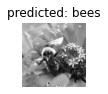

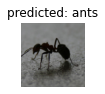

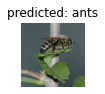

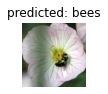

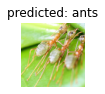

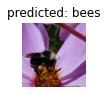

In [20]:
visualize_model(model_conv)

plt.ioff()
plt.show()